## Model ML

## Import Semua Packages/Library yang Digunakan

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, \
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             accuracy_score)
import cv2
import numpy as np 
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


## Data Wrangling

### Training Data

In [2]:
train2=os.listdir("train")

In [3]:
train2

['Acne and Rosacea',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis',
 'Bullous Disease',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue Diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and Related Diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

In [ ]:
# cat2=['Acne and Rosacea']

In [ ]:
# cat = ['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis']

In [4]:
def data_dictionary():
    path_train = "train/"  # Update the path to your train directory
    path_test = "test/"    # Update the path to your test directory
    
    list_train = os.listdir(path_train)
    list_train1 = os.listdir(path_test)
    
    train_dictionary = {"image_path": [], "target": []}
    
    k = 0
    for i in list_train:
        path_disease_train = os.path.join(path_train, i)
        image_list_train = os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train = os.path.join(path_disease_train, j)
            if img_path_train != "train/Normal/34.avif":
                train_dictionary["image_path"].append(img_path_train)
                train_dictionary['target'].append(k) 
        k += 1
    
    for i in list_train1:
        path_disease_test = os.path.join(path_test, i)
        image_list_test = os.listdir(path_disease_test)
        for j in image_list_test:
            img_path_train = os.path.join(path_disease_test, j)
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(4)
    
    train_df = pd.DataFrame(train_dictionary)
    return train_df

train = data_dictionary()


In [5]:
import imagehash

def remove_duplicate_images(df):
    # Create a column for image hashes
    df['image_hash'] = df['image_path'].apply(lambda x: imagehash.average_hash(Image.open(x)))
    
    # Find duplicates based on image hash
    duplicate_indices = df.duplicated(subset=['image_hash'], keep='first')
    
    # Filter out duplicates
    df_cleaned = df[~duplicate_indices].copy()
    
    # Drop the image hash column
    df_cleaned.drop(columns=['image_hash'], inplace=True)
    
    return df_cleaned

# Generate train dataframe
train_df = data_dictionary()

# Remove duplicates
train_df_cleaned = remove_duplicate_images(train_df)

# Print cleaned dataframe
print(train_df_cleaned.head())

                                      image_path  target
0        train/Acne and Rosacea\07Acne081101.jpg       0
1   train/Acne and Rosacea\07AcnePittedScars.jpg       0
2  train/Acne and Rosacea\07AcnePittedScars1.jpg       0
3   train/Acne and Rosacea\07PerioralDermEye.jpg       0
4  train/Acne and Rosacea\07PerioralDermNose.jpg       0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20429 entries, 0 to 20428
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  20429 non-null  object
 1   target      20429 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 319.3+ KB


In [7]:
import cv2

#inisialisasi list
images=[]
label=[]

#Iterasi Melalui Daftar Path Gambar
for i in train['image_path']:
    # Memuat dan Memproses Gambar
    if i!="train/Normal/34.avif":
        img=cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Mengkonversi Warna
        img=cv2.resize(img,(180,180))
        
        images.append(img)


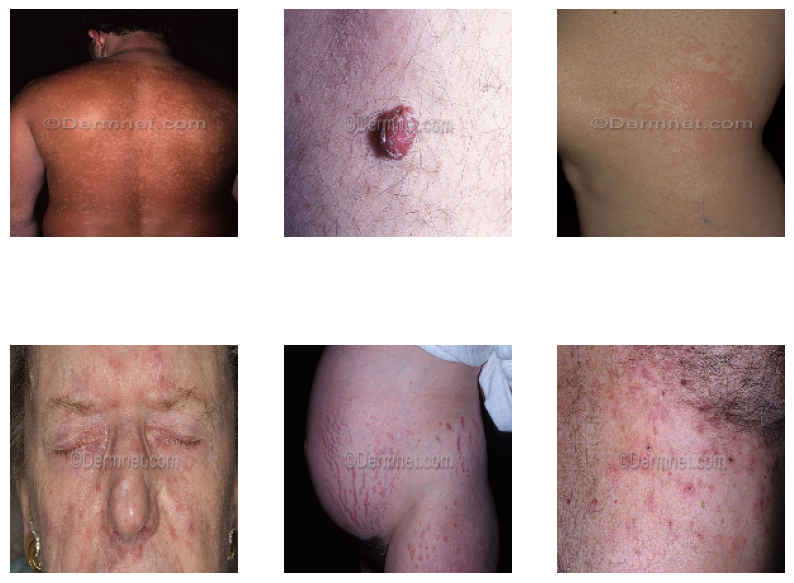

In [8]:
# Create a list of example inputs to our Gradio demo
example_list = [image for image in random.sample(images, k=6)]

# Plot the images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for ax, img_array in zip(axes.ravel(), example_list):
    ax.imshow(img_array)
    ax.axis('off')

plt.show()


In [9]:
label = train['target']

In [10]:
len(label)

20429

In [11]:
data = np.array(images)
label = np.array(label)

data.shape

(20429, 180, 180, 3)

In [12]:
label.shape

(20429,)

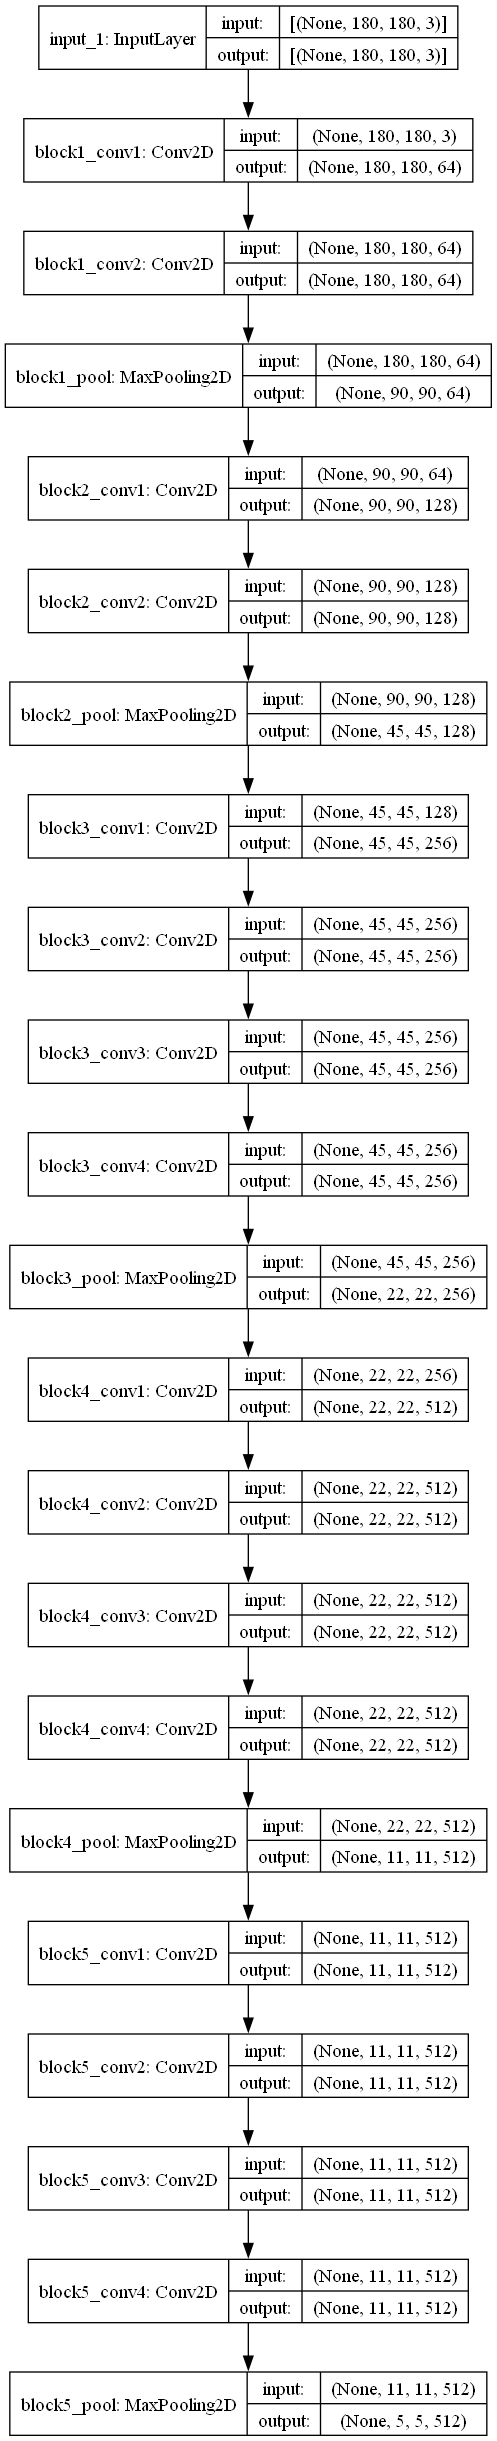

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import plot_model  # Use TensorFlow's built-in Keras utils
import pydot

# Load the VGG19 model with pretrained ImageNet weights, excluding the top fully connected layers
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Make all layers non-trainable
for layer in vgg_model.layers:
    layer.trainable = False

# Plot the model architecture
plot_model(vgg_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


## Kode baru 2

In [ ]:
# Ensure the environment is reset
import gc
gc.collect()
tf.keras.backend.clear_session()

# Preprocess labels
labels = np.array(train['target'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=23)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=23)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Build the model using Transfer Learning with MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the CNN model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Mengganti Flatten dengan GlobalAveragePooling2D
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(23, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpoint
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val), 
                    epochs=100,  # Mulai dengan 100 epochs
                    callbacks=callbacks)

# Unfreeze some layers of the base model
for layer in base_model.layers[-20:]:  # Unfreeze 20 layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training the model
history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_val, y_val), 
                         epochs=100, 
                         callbacks=callbacks)

# Save the final model
model.save('final_model.h5')

# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history_fine.history['accuracy'], label='fine_tune_train_accuracy')
plt.plot(history_fine.history['val_accuracy'], label='fine_tune_val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history_fine.history['loss'], label='fine_tune_train_loss')
plt.plot(history_fine.history['val_loss'], label='fine_tune_val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


## KODE ORI

In [14]:
# Ensure the environment is reset
import gc
gc.collect()
tf.keras.backend.clear_session()

# Preprocess labels
labels = np.array(train['target'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=23)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=23)

# # kode baru
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Build the model using Transfer Learning with MobileNetV2
# base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3), include_top=False, weights='imagenet')
# base_model.trainable = False  # Freeze the base model

# # kode baru


# Build the CNN model
model = Sequential([
    # base_model,
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(23, activation='softmax')
])


Epoch 1/250
511/511 [==============================] - 438s 855ms/step - loss: 3.7984 - accuracy: 0.0863 - val_loss: 3.0393 - val_accuracy: 0.1040
Epoch 2/250
511/511 [==============================] - 395s 773ms/step - loss: 3.1395 - accuracy: 0.1264 - val_loss: 2.8066 - val_accuracy: 0.1772
Epoch 3/250
511/511 [==============================] - 394s 771ms/step - loss: 2.9462 - accuracy: 0.1550 - val_loss: 2.9315 - val_accuracy: 0.1363
Epoch 4/250
511/511 [==============================] - 391s 765ms/step - loss: 2.8299 - accuracy: 0.1760 - val_loss: 2.7331 - val_accuracy: 0.1948
Epoch 5/250
511/511 [==============================] - 445s 871ms/step - loss: 2.7666 - accuracy: 0.1878 - val_loss: 2.8662 - val_accuracy: 0.1598
Epoch 6/250
511/511 [==============================] - 478s 935ms/step - loss: 2.7235 - accuracy: 0.1994 - val_loss: 2.7052 - val_accuracy: 0.1943
Epoch 7/250
511/511 [==============================] - 472s 923ms/step - loss: 2.6727 - accuracy: 0.2087 - val_loss: 2

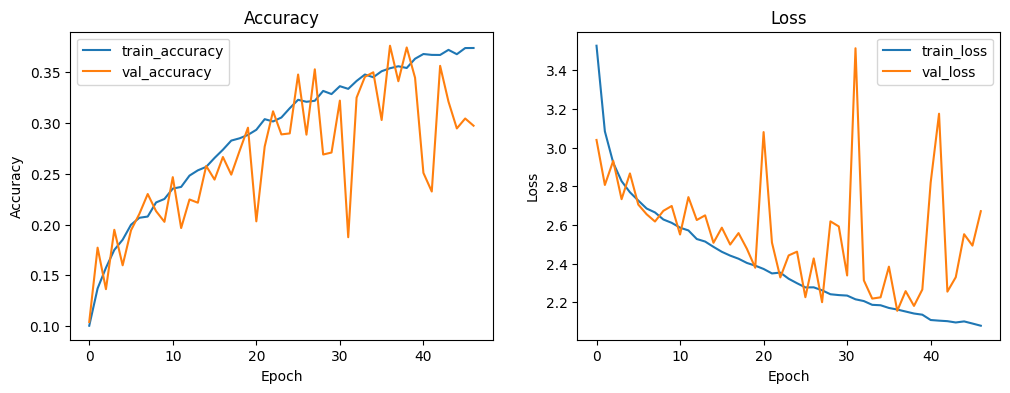

In [15]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpoint
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train the model
# history = model.fit(X_train, y_train, 
#                     validation_data=(X_val, y_val), 
#                     epochs=28, 
#                     batch_size=32, 
#                     callbacks=callbacks)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val), 
                    epochs=250, 
                    callbacks=callbacks)

# Save the final model
model.save('final_model.h5')

# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


## Kode baru 3

Epoch 1/250
511/511 [==============================] - 363s 701ms/step - loss: 3.2072 - accuracy: 0.1604 - val_loss: 2.5136 - val_accuracy: 0.2577
Epoch 2/250
511/511 [==============================] - 275s 537ms/step - loss: 2.5759 - accuracy: 0.2424 - val_loss: 2.3954 - val_accuracy: 0.2930
Epoch 3/250
511/511 [==============================] - 279s 546ms/step - loss: 2.4745 - accuracy: 0.2700 - val_loss: 2.3934 - val_accuracy: 0.2873
Epoch 4/250
511/511 [==============================] - 276s 540ms/step - loss: 2.4125 - accuracy: 0.2843 - val_loss: 2.3742 - val_accuracy: 0.2988
Epoch 5/250
511/511 [==============================] - 271s 529ms/step - loss: 2.4009 - accuracy: 0.2855 - val_loss: 2.3684 - val_accuracy: 0.3069
Epoch 6/250
511/511 [==============================] - 347s 678ms/step - loss: 2.3739 - accuracy: 0.3021 - val_loss: 2.3614 - val_accuracy: 0.2888
Epoch 7/250
511/511 [==============================] - 393s 770ms/step - loss: 2.3594 - accuracy: 0.3047 - val_loss: 2

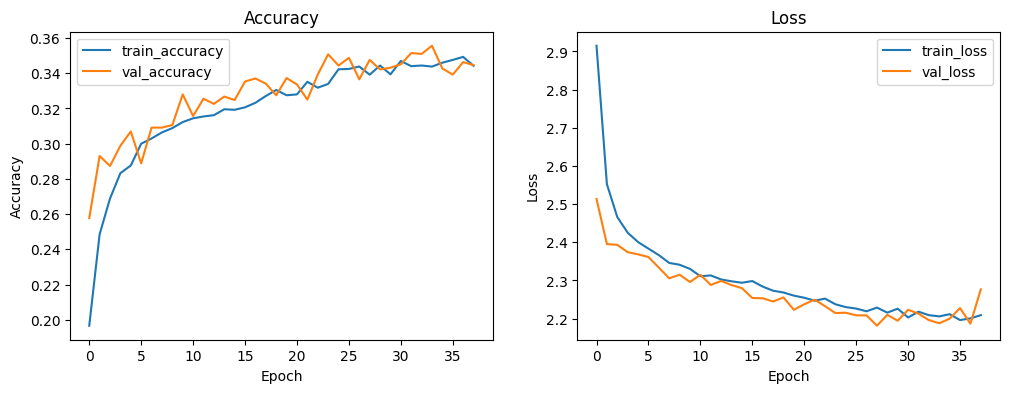

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, 
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, 
                             accuracy_score)
import cv2
import numpy as np 
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import power_transform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

train2=os.listdir("train")

def data_dictionary():
    path_train = "train/"  # Update the path to your train directory
    path_test = "test/"    # Update the path to your test directory
    
    list_train = os.listdir(path_train)
    list_train1 = os.listdir(path_test)
    
    train_dictionary = {"image_path": [], "target": []}
    
    k = 0
    for i in list_train:
        path_disease_train = os.path.join(path_train, i)
        image_list_train = os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train = os.path.join(path_disease_train, j)
            if img_path_train != "train/Normal/34.avif":
                train_dictionary["image_path"].append(img_path_train)
                train_dictionary['target'].append(k) 
        k += 1
    
    for i in list_train1:
        path_disease_test = os.path.join(path_test, i)
        image_list_test = os.listdir(path_disease_test)
        for j in image_list_test:
            img_path_train = os.path.join(path_disease_test, j)
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(4)
    
    train_df = pd.DataFrame(train_dictionary)
    return train_df

train = data_dictionary()


import cv2

#inisialisasi list
images=[]
label=[]

#Iterasi Melalui Daftar Path Gambar
for i in train['image_path']:
    # Memuat dan Memproses Gambar
    if i!="train/Normal/34.avif":
        img=cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Mengkonversi Warna
        img=cv2.resize(img,(180,180))
        
        images.append(img)

# Ensure the environment is reset
import gc
gc.collect()
tf.keras.backend.clear_session()

# Preprocess labels
labels = np.array(train['target'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, num_classes=23)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=23)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Load the InceptionV3 model
base_model = InceptionV3(input_shape=(180, 180, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the CNN model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(23, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpoint
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val), 
                    epochs=250, 
                    callbacks=callbacks)

# Save the final model
model.save('final_model.h5')

# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
import pylab as pl
plt.title("skin detection  using VGG19 ")

ax= plt.subplot()
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', ax=ax);
pl.show()

confusion_matrix = classification_report(y_test, y_pred2)

### Convert ke dalam tensorflow js

In [ ]:
import os
import subprocess

# Simpan model terbaik ke direktori yang ditentukan
save_dir = os.path.join('/tmp/', 'mobilenetv2')
os.makedirs(save_dir, exist_ok=True)
model.save(os.path.join(save_dir, 'saved_model.h5'))

# Direktori kerja untuk subprocess
work_dir = os.path.join('c:', os.sep, 'tmp', 'mobilenetv2')

# Konversi model menggunakan tensorflowjs_converter
conversion_command = ["tensorflowjs_converter", "--input_format=keras", "saved_model.h5", "/tmp/tfjs_mobilenetv2"]
subprocess.run(conversion_command, cwd=work_dir, check=True)

# Zip modeldata
zip_command = ["zip", "-r", "modeldata.zip", "/tmp/tfjs_mobilenetv2/"]
subprocess.run(zip_command, cwd=work_dir, check=True)


In [ ]:
conversion_command = ["C:/Users/username/AppData/Local/Programs/Python/Python38/Scripts/tensorflowjs_converter", "--input_format=keras", "saved_model.h5", "/tmp/tfjs_mobilenetv2"]
subprocess.run(conversion_command, cwd=work_dir, check=True)


In [ ]:
# Direktori kerja untuk subprocess
work_dir = os.path.join('c:', os.sep, 'tmp', 'mobilenetv2')

# Konversi model menggunakan tensorflowjs_converter
conversion_command = ["tensorflowjs_converter", "--input_format=keras", "saved_model.h5", "/tmp/tfjs_mobilenetv2"]
subprocess.run(conversion_command, cwd=work_dir, check=True)

# Zip modeldata
zip_command = ["zip", "-r", "modeldata.zip", "/tmp/tfjs_mobilenetv2/"]
subprocess.run(zip_command, cwd=work_dir, check=True)


#### nyoba lain


In [ ]:
# 1. Library Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, 
                          Dropout, Input, GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)
import cv2
import numpy as np 
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, power_transform
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 2. Data Preparation
def data_dictionary():
    path_train = "train/"  # Update the path to your train directory
    path_test = "test/"    # Update the path to your test directory
    
    list_train = os.listdir(path_train)
    list_train1 = os.listdir(path_test)
    
    train_dictionary = {"image_path": [], "target": []}
    
    k = 0
    for i in list_train:
        path_disease_train = os.path.join(path_train, i)
        image_list_train = os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train = os.path.join(path_disease_train, j)
            if img_path_train != "train/Normal/34.avif":
                train_dictionary["image_path"].append(img_path_train)
                train_dictionary['target'].append(k) 
        k += 1
    
    for i in list_train1:
        path_disease_test = os.path.join(path_test, i)
        image_list_test = os.listdir(path_disease_test)
        for j in image_list_test:
            img_path_train = os.path.join(path_disease_test, j)
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(4)
    
    train_df = pd.DataFrame(train_dictionary)
    return train_df

train_df = data_dictionary()

# Preprocess images
images = []
labels = []
for i in range(len(train_df['image_path'])):
    if train_df['image_path'][i] != "train/Normal/34.avif":
        img = cv2.imread(train_df['image_path'][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (180, 180))
        img = img.astype(np.float32) / 255.0  # Normalize pixel values
        images.append(img)
        labels.append(train_df['target'][i])

images = np.array(images)
labels = np.array(labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# 3. Model Building
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(23, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 4. Model Training
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(train_generator, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping, checkpoint])

# 5. Model Evaluation
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Load the best model and evaluate again
best_model = tf.keras.models.load_model('best_model.h5')
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Best Model Validation Accuracy: {val_accuracy * 100:.2f}%")

In [ ]:

# Save model architecture to JSON
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights to HDF5 (for example, .bin format)
best_model.save_weights("model_weights.h5")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.load_weights("model_weights.bin")